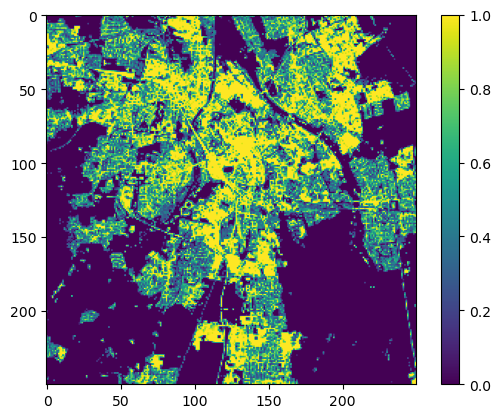

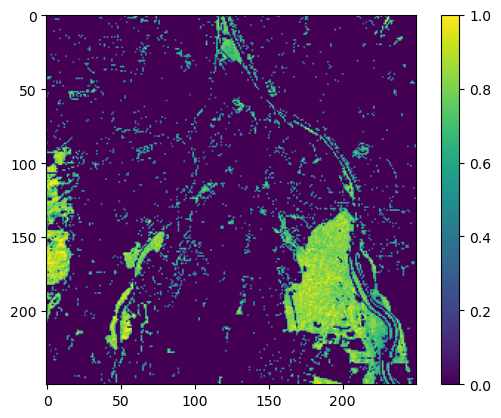

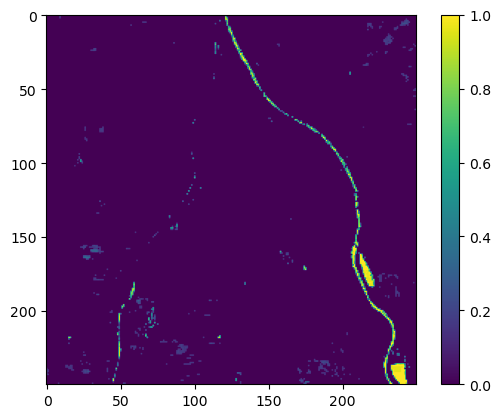

In [1]:
# first, normalize the Tif file
from osgeo import gdal, osr
import matplotlib.pyplot as plt


def Geotiff_norm(in_path, out_path):
    input_im = gdal.Open(in_path)
    data = []
    for i in range(input_im.RasterCount):
        input_im_band = input_im.GetRasterBand(i+1)
        stats = input_im_band.GetStatistics(False, True)
        min_value, max_value = stats[0], stats[1]
        input_im_band_ar = input_im.GetRasterBand(i+1).ReadAsArray()
        output_im_band_ar = (input_im_band_ar - min_value) / (max_value - min_value)
        data.append(output_im_band_ar.copy())

    output_file = out_path
    driver = gdal.GetDriverByName('GTiff')
    dst_ds = driver.Create(output_file,
                           input_im.RasterXSize,
                           input_im.RasterYSize,
                           input_im.RasterCount,
                           gdal.GDT_Float32)
    for i in range(input_im.RasterCount):
        dst_ds.GetRasterBand(i+1).WriteArray(data[i])

    dst_ds.SetGeoTransform(input_im.GetGeoTransform())
    wkt = input_im.GetProjection()
    # setting spatial reference of output raster
    srs = osr.SpatialReference()
    srs.ImportFromWkt(wkt)
    dst_ds.SetProjection(srs.ExportToWkt())

    input_im = None
    dst_ds = None
    
    
def Geotiff_show(in_path):
    input_im = gdal.Open(in_path)

    for i in range(input_im.RasterCount):
        input_im_band_ar = input_im.GetRasterBand(i+1).ReadAsArray()
        plt.imshow(input_im_band_ar)
        plt.colorbar()
        plt.show()
        
    input_im = None
    dst_ds = None
    

Geotiff_norm('./Dataset_res250/CWSL_resampled.tif', './Dataset_res250/CWSL_norm.tif')
Geotiff_show('./Dataset_res250/CWSL_norm.tif')

In [5]:
# then divide and analyse datasets as 5-fold
import os
import pickle
import pandas as pd

def build_aux_set(train_set):

    step = 20

    aux_set = []
    remain_train_set = []

    for index, element in enumerate(train_set):
        if index % step == 0:
            aux_set.append(element)
        else:
            remain_train_set.append(element)

    return remain_train_set, aux_set

# build up the given path
def build_folder_and_clean(path):
    check = os.path.exists(path)
    if check:
        for root, dirs, files in os.walk(path, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))
    else:
        os.makedirs(path)


def get_set(lists, indexs):
    rtn = []
    for index in indexs:
        rtn += lists[index]
    return rtn


in_path = './Dataset_res250/Dataset_Separation/'
out_path = './Dataset_res250/Folds_Info/'
build_folder_and_clean(out_path)

files = os.listdir(in_path)
files.sort()

fold_count = 5
fold_len = len(files) // fold_count
folds = [files[i:i+fold_len] for i in range(0, len(files), fold_len)]

for i in range(fold_count):
    train_index = [(i+2)%5, (i+3)%5, (i+4)%5]
    test_index = [(i+1)%5]
    eval_index = [i%5]
    
    train_set = get_set(folds, train_index)
    test_set = get_set(folds, test_index)
    eval_set = get_set(folds, eval_index)
    train_set, aux_set = build_aux_set(train_set)

    print(f'length of train_set: {len(train_set)} in fold {i}')
    print(f'length of aux_set: {len(aux_set)} in fold {i}')
    
    # save set divide info
    with open(out_path + f'divide_set_{i}.info', 'wb') as f:
        pickle.dump([train_set, test_set, eval_set, aux_set], f)
            
    # work on normalization, noticing:
    #     - train set only contains readings from non-official stations on 60% of time slices
    #     - normalization info should be only analyzed within these data
    dic_op_df = {}
    #         - only on 60% of time slices
    for idx, file in enumerate(train_set):
        print(f'Working on fold {i}, file {idx}/{len(train_set)}', end="\r", flush=True)
        df = pd.read_csv(in_path + file, sep=';')
        for op in df['op'].unique():
            # - only from non-official stations
            if op not in ['s_label_0', 's_label_1', 's_label_2', 's_label_3']:
                df_op = df[df['op']==op]
                if op not in dic_op_df.keys():
                    dic_op_df[op] = df_op
                else:
                    dic_op_df[op] = pd.concat([dic_op_df[op], df_op])

    # calculate mean and std then dump result
    min_max_list = ['hur', 'plev', 'precip', 'globalrad']
    z_score_list = ['mcpm10', 'mcpm2p5', 'ta', 'wsx', 'wsy']
    
    dic_op_meanstd = {}
    dic_op_minmax = {}
    with open(out_path + f'norm_{i}.log', 'w') as f:
        for op in dic_op_df.keys():
            if op in min_max_list:
                op_max = dic_op_df[op]['Result'].max()
                op_min = dic_op_df[op]['Result'].min()
                dic_op_minmax[op] = [op_min, op_max]
                f.write(f'norm log for op: {op} ---- len: {len(dic_op_df[op])}, min: {op_min}, max: {op_max}\n')
            if op in z_score_list:
                op_mean = dic_op_df[op]['Result'].mean()
                op_std = dic_op_df[op]['Result'].std()
                dic_op_meanstd[op] = [op_mean, op_std]
                f.write(f'norm log for op: {op} ---- len: {len(dic_op_df[op])}, mean: {op_mean}, std: {op_std}\n')
            else:
                op_mean = dic_op_df[op]['Result'].mean()
                op_std = dic_op_df[op]['Result'].std()
                dic_op_meanstd[op] = [op_mean, op_std]
                f.write(f'norm log for op: {op} ---- len: {len(dic_op_df[op])}, mean: {op_mean}, std: {op_std}\n')

    with open(out_path + f'norm_{i}.info', 'wb') as f:
        pickle.dump([dic_op_minmax, dic_op_meanstd], f)
        
                

length of train_set: 12377 in fold 0
length of aux_set: 652 in fold 0
length of train_set: 12377 in fold 1
length of aux_set: 652 in fold 1
length of train_set: 12377 in fold 2
length of aux_set: 652 in fold 2
length of train_set: 12377 in fold 3
length of aux_set: 652 in fold 3
length of train_set: 12377 in fold 4
length of aux_set: 652 in fold 4
